In [437]:
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
data = []

## Conversor Alfabetos

one_letter	two_letter	ipa
a	AA	ɑ
@	AE	æ
A	AH	ʌ
c	AO	ɔ
W	AW	aʊ
x	AX	ə
N/A	A	ɚ
Y	AY	aɪ
E	EH	ɛ
R	ER	ɝ
e	EY	eɪ
I	IH	ɪ
X	IX	ɨ
i	IY	i
o	OW	oʊ
O	OY	ɔɪ
U	UH	ʊ
u	UW	u
N/A	UX	ʉ
b	B	b
C	CH	tʃ
d	D	d
D	DH	ð
F	DX	ɾ
L	EL	l̩
M	EM	m̩
N	EN	n̩
f	F	f
g	G	ɡ
h	HH	h
h	H	h
J	JH	dʒ
k	K	k
l	L	l
m	M	m
n	N	n
G	NG	ŋ
G	NX	ŋ
p	P	p
Q	Q	ʔ
r	R	ɹ
s	S	s
S	SH	ʃ
t	T	t
T	TH	θ
v	V	v
w	W	w
H	WH	ʍ
y	Y	j
z	Z	z
Z	ZH	ʒ
a~		ɑ~
e~		e~
i~		i~
o~		o~
u~		u~
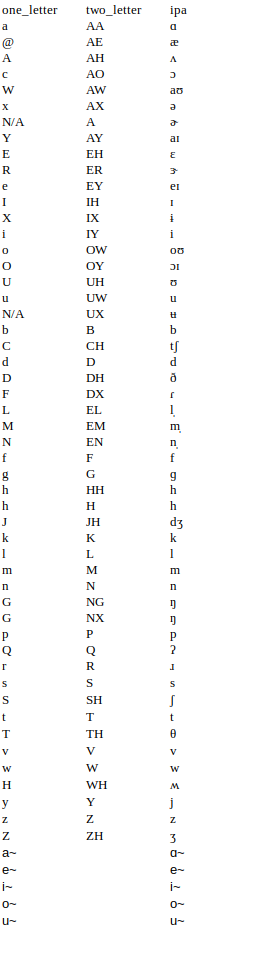

In [261]:
conversor = pd.read_clipboard()

In [262]:
conversor.head()

,one_letter,two_letter,ipa
0,a,AA,ɑ
1,@,AE,æ
2,A,AH,ʌ
3,c,AO,ɔ
4,W,AW,aʊ


## Default Class

In [531]:
import glob, os
from io import StringIO
import collections, numpy
import pandas as pd
import numpy as np
import plotly.graph_objs as go

def get_words(x):
	temp_result = x.split('\t\t')[0]
	if temp_result.find('\t') > -1:
			temp_result = x.split('\t')[0]
	if temp_result.find(' ') > -1:
			temp_result = x.split()[0]
	return temp_result
def get_phonemes(x):
	temp_result = ""
	if x.find('\t\t') > -1:
			temp_result = x.split('\t\t')[1]
	if (temp_result.find('\t') > -1) or (len(temp_result) == 0 and x.find('\t') > -1):
			temp_result = x.split('\t')[1]
	if (temp_result.find(' ') > -1) or (len(temp_result) == 0 and x.find(' ') > -1):
			temp_result = x.split()[1:]
	return temp_result
	
def process_data(name, normalized=True, reference_dict=None):
	perdas = 0
	if name == 'cmu':
		df = pd.read_csv('../data/external/cmudict.dict', sep='\t', header=None, names=['lines'])
		df.lines = df.lines.str.replace('\d', '') #Dígitos representam apenas entonação https://en.wikipedia.org/wiki/ARPABET
		df['words'] = df.lines.str.split().str[0]
		df['phonemes']  = df.lines.str.split().str[1:]
		df = df.drop(labels=df[df.lines.str.contains('#')].index).reset_index(drop=True)
	if name == 'dict_br':
		df = pd.read_csv('../data/external/dictionary.dic', sep=';', header=None, names=['lines'])
		df.lines = df.lines.str.replace('sp$', '').str.replace('sp $', '')
		df = (
				df
				.drop(labels=df[df.lines.str.contains('\[\]')].index)
				.reset_index(drop=True)
		)
		df['words'] = df.lines.apply(get_words)
		df['phonemes'] = df.lines.apply(get_phonemes)
		df = (
			df
			.drop(labels=df[df.phonemes.apply(lambda x : 'sil' in x)].index)
			.reset_index(drop=True)
		)
	if name == 'laps' or 'const' or 'cell':
		myBigString = ""
		if name == 'laps':
			for file in glob.glob("../data/external/LapsBM1.4/*/*.txt", recursive=True):
				myBigString += open(file).read() + ' '
		if name == 'const':
			for file in glob.glob("../data/external/constituicaoBR/*.txt", recursive=True):
				myBigString += open(file).read() + ' '
		if name == 'cell':
			import pysrt
			for file in glob.glob("../data/external/Cellbit/originals/*.srt", recursive=True):
				subs = pysrt.open(file)
				myBigString += subs.text
			myBigString = myBigString.replace('\n', '').lower()
		t = collections.Counter(numpy.array(myBigString.split()))
		del myBigString #save memory
		df = pd.DataFrame(list(zip(t.keys(), t.values())), columns=['words', 'ocorrencias'])
		try:
			antes = len(df)
			df = df.merge(reference_dict, on='words')
			depois = len(df)
			perdas = 1.0 - (depois/antes)
		except:
			raise Exception('Deve definir um dicionário para processar')
		df.phonemes = df.phonemes * df.ocorrencias #multiplica as ocorrencias



	unique, counts = np.unique(
			np.hstack(
					df.phonemes.values
			),
			return_counts=True)

	phonemes = pd.DataFrame(list(zip(unique, counts)), columns=['phoneme', 'cmu_dict'])
	
	if name == 'cmu':
		phonemes = (
				phonemes
				.merge(conversor, left_on='phoneme', right_on='two_letter')
				.sort_values(by='cmu_dict', ascending=False)
		)
	else:
		phonemes = (
	    phonemes
	    .merge(conversor.drop_duplicates(subset='one_letter'),left_on='phoneme', right_on='one_letter')
	    .sort_values(by='cmu_dict', ascending=False)
	    )

	data = go.Bar(
						x=phonemes.ipa,
						y=(
								100 *
								phonemes.cmu_dict / 
								phonemes.cmu_dict.sum()
						) if normalized else phonemes.cmu_dict,
						name=name
			)

	return df, phonemes, data, perdas


## CMU

In [458]:
cmu_l = process_data('cmu')

In [459]:
data = []
data.append(cmu_l[2])

## Dict PT_BR

In [460]:
dict_l = process_data('dict_br')
data.append(dict_l[2])

# Voz

## Laps

In [479]:
dict_laps = process_data('laps', reference_dict=dict_l[0])
data.append(dict_laps[2])

In [483]:
layout = go.Layout(
)

fig = go.Figure(data=data, layout=layout)
py.iplot(data, filename='basic-bar')

## Constituição

In [493]:
dict_const = process_data('const', reference_dict=dict_l[0])
data.append(dict_const[2])

In [494]:
layout = go.Layout(
)

fig = go.Figure(data=data, layout=layout)
py.iplot(data, filename='basic-bar')

## Cellbit

In [532]:
dict_cell = process_data('cell', reference_dict=dict_l[0])
data.append(dict_cell[2])

In [537]:
dict_cell[0]

,words,ocorrencias,lines,phonemes
0,bom,21,bom\t\tb o~,"[b, o~, b, o~, b, o~, b, o~, b, o~, b, o~, b, ..."
1,eu,1358,eu\t\te u,"[e, u, e, u, e, u, e, u, e, u, e, u, e, u, e, ..."
2,sou,32,sou\t\ts o u,"[s, o, u, s, o, u, s, o, u, s, o, u, s, o, u, ..."
3,bem,59,bem\t\tb e~ i,"[b, e~, i, b, e~, i, b, e~, i, b, e~, i, b, e~..."
4,vindo,5,vindo\t\tv i~ d u,"[v, i~, d, u, v, i~, d, u, v, i~, d, u, v, i~,..."
5,a,872,a\t\ta,"[a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, ..."
6,mais,257,mais\t\tm a i s,"[m, a, i, s, m, a, i, s, m, a, i, s, m, a, i, ..."
7,um,806,um\t\tu~,"[u~, u~, u~, u~, u~, u~, u~, u~, u~, u~, u~, u..."
8,nessa,30,nessa\t\tn E s a,"[n, E, s, a, n, E, s, a, n, E, s, a, n, E, s, ..."
9,nesse,37,nesse\t\tn e s i,"[n, e, s, i, n, e, s, i, n, e, s, i, n, e, s, ..."


In [533]:
layout = go.Layout(
)

fig = go.Figure(data=data, layout=layout)
py.iplot(data, filename='basic-bar')